In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from lib.read_data import dataset,Datasets,readDataWithRawScore
from math import copysign

from sklearn.pipeline import Pipeline

# feature extractors
from sklearn.decomposition import PCA
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
# finetuning
from sklearn.model_selection import GridSearchCV
# validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# plot
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def run_display_output(classifier,test,DRAW=False):
    '''
    get confusion matrix and auc score for test dataset
    (optional) draw roc curve
    '''
    pred = classifier.predict(test[0])
    tn, fp, fn, tp = confusion_matrix(test[1],pred).ravel()#confusion matrix
    print(tn,fp,fn,tp)
    sensitivity = tp/(fn+tp)
    specificity = tn/(fp+tn)
    prods = classifier.predict_proba(test[0])[:,1]
    fpr, tpr, _ = metrics.roc_curve(test[1], prods)
    score = metrics.auc(fpr,tpr) #auc score
    if DRAW:
        draw_roc_curve(fpr,tpr,score)

    return sensitivity, specificity, score

def display_res_gavin_and_best_model(param_grid,pipeline,mvid,filename=None):
    '''
    use model defined by pipeline to fit mvid Dataset
    gridsearchCV determine the parameters given in param_grid
    (optional) save the model in path given in filename
    '''
    classifier = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid)

    print('Start training...')
    classifier.fit(mvid[0],mvid[1])
    print('Model Description:\n',classifier.best_estimator_)
    if filename:
        pickle.dump(classifier,open(filename,'wb'))
        print('Saved model to path:',filename)
    sensitivity,specificity,score = run_display_output(classifier,[mvid[2],mvid[3]])
    print('>>> best model results: sensitivity: {:.{prec}}\tspecificity: {:.{prec}f}\tauc:{}'.\
    format(sensitivity,specificity,score,prec=3))
    return classifier

In [3]:
if __name__=='__main__':
    
    def load_bonderWestraData(path):
        data = pd.read_csv(path,sep=',',index_col=0)
        def binarize(row):
            if row > 0:
                return 1
            else:
                return 0
        data['direction'] = data['zscore'].apply(binarize)
        print('Raw data loaded.')
        dataset = readDataWithRawScore(data,'direction')
        return dataset
    
    bonder_path = 'data/bonder_withzscore.csv'
    westra_allFeat_path = 'data/westra_all_with_zscore.csv'
    westra_bonderFeat_path = 'data/westra_bonderfeat_with_zscore.csv'

    bonder = load_bonderWestraData(bonder_path)
    westra_allFeat = load_bonderWestraData(westra_allFeat_path)
    westra_bonderFeat = load_bonderWestraData(westra_bonderFeat_path)

    print('Bonder dataset loaded.',bonder.train.values.shape)
    print('Westra with all features dataset loaded.',westra_allFeat.train.values.shape)
    print('Westra with bonder features dataset loaded.',
           westra_bonderFeat.train.values.shape)

Raw data loaded.
Data Normalized.
Raw data loaded.
Data Normalized.
Raw data loaded.
Data Normalized.
Bonder dataset loaded. (2131, 9)
Westra with all features dataset loaded. (2644, 35)
Westra with bonder features dataset loaded. (2644, 9)


In [4]:
print(bonder.train.values['cpgName'].head())
westra_cpgs = set(westra_bonderFeat.train.values['cpgName']+\
            westra_bonderFeat.test.values['cpgName'])
bonder_cpgs = set(bonder.train.values['cpgName']+\
            bonder.test.values['cpgName'])

# print(len(westra_cpgs - bonder_cpgs))
# print(westra_cpgs)

0    cg05542681_ENSG00000127585
1    cg06180606_ENSG00000103202
2    cg02059867_ENSG00000108352
3    cg12227172_ENSG00000161551
4    cg18005867_ENSG00000250312
Name: cpgName, dtype: object


In [5]:
    # get the error cases and the correct cases
    eqtm_data = bonder
    feature_list = [col for col in eqtm_data.train.values.columns
                    if col not in ['zscore','cpgName']]
    train_data = eqtm_data.train.values[feature_list]
    test_data = eqtm_data.test.values[feature_list]
    
    # ============random forest================
    pipeline_ranfor = Pipeline(steps=[('ranfor',
                                       RandomForestClassifier())])
    n_estimators = [10,50,100]
    class_weight = ['balanced',{1:4,0:1},{1:2,0:1}]
    param_grid_ranfor = [{'ranfor__n_estimators':n_estimators,
                        'ranfor__class_weight':class_weight}]
    classifier_ranfor = display_res_gavin_and_best_model(
                        param_grid_ranfor,
                        pipeline_ranfor,
                        [train_data,
                         eqtm_data.train.labels,
                         test_data,
                         eqtm_data.test.labels])
    # ==========================================
    
    # ===========knn============================
    pipeline_kneighbor = Pipeline(steps=[('kneighbor',
                                          KNeighborsClassifier())])
    # print(pipeline_kneighbor.get_params().keys())
    n_neighbors = range(2,10)
    weights = ['uniform','distance']
    # algorithms = ['auto']
    # leaf_size = [20,30,40,50]
    # p = [1,2,3]
    param_grid_kneighbor = [{'kneighbor__n_neighbors':n_neighbors,
                            'kneighbor__weights':weights}]#,
                            # 'kneighbor__algorithms':algorithms}]#,
                            # 'kneighbor__leaf_size':leaf_size,
                            # 'kneighbor__p':p}]
    classifier_kneighbor = display_res_gavin_and_best_model(
                            param_grid_kneighbor,
                            pipeline_kneighbor,
                            [train_data,
                         eqtm_data.train.labels,
                         test_data,
                         eqtm_data.test.labels])
    # ==========================================
    
    
#     model = LogisticRegression()
#     model.fit(train_data,eqtm_data.train.labels)
    pred = classifier_kneighbor.predict(test_data)

Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('ranfor', RandomForestClassifier(bootstrap=True, class_weight={1: 2, 0: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
174 181 51 305
>>> best model results: sensitivity: 0.857	specificity: 0.490	auc:0.6923959487260642
Start training...
Model Description:
 Pipeline(memory=None,
     steps=[('kneighbor', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance'))])
228 127 62 294
>>> best model results: sensitivity: 0.826	specificity: 0.642	auc:0.8079917708498179


In [32]:
    classifier_ranfor.best_estimator_.steps[0][1].feature_importances_
#     train_data.columns

array([0.17848721, 0.04171662, 0.14669345, 0.08535618, 0.07948827,
       0.11520724, 0.35305103])

In [7]:
    # error cases for negative prediction
    error_cases_neg = eqtm_data.test.values.loc[np.where(pred[np.logical_and(pred!=eqtm_data.test.labels,pred==0.)]==0.)]
    correct_cases_neg = eqtm_data.test.values.loc[np.where(pred[np.logical_and(pred==eqtm_data.test.labels,pred==0.)]==0.)]
    
    # error cases for positive prediction
    error_cases_pos = eqtm_data.test.values.loc[np.where(pred[np.logical_and(pred!=eqtm_data.test.labels,pred==1.)]==1.)]
    correct_cases_pos = eqtm_data.test.values.loc[np.where(pred[np.logical_and(pred==eqtm_data.test.labels,pred==1.)]==1.)]

In [14]:
    print(error_cases_neg.loc[1,:])
#     print(error_cases_pos.head())

cpgName                                                           cg15462411_ENSG00000262877
H3K27ac_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                              1
H3K9me3_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                              0
H3K27me3_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                      0.964286
H3K36me3_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                             0
H3K4me1_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                              1
H3K4me3_ImputedGapped_Bonder_celltypes_MJ_final_eqtms_unique_                              1
TSS_Distance                                                                      0.00100715
zscore                                                                              0.392604
Name: 1, dtype: object


Negative cases.


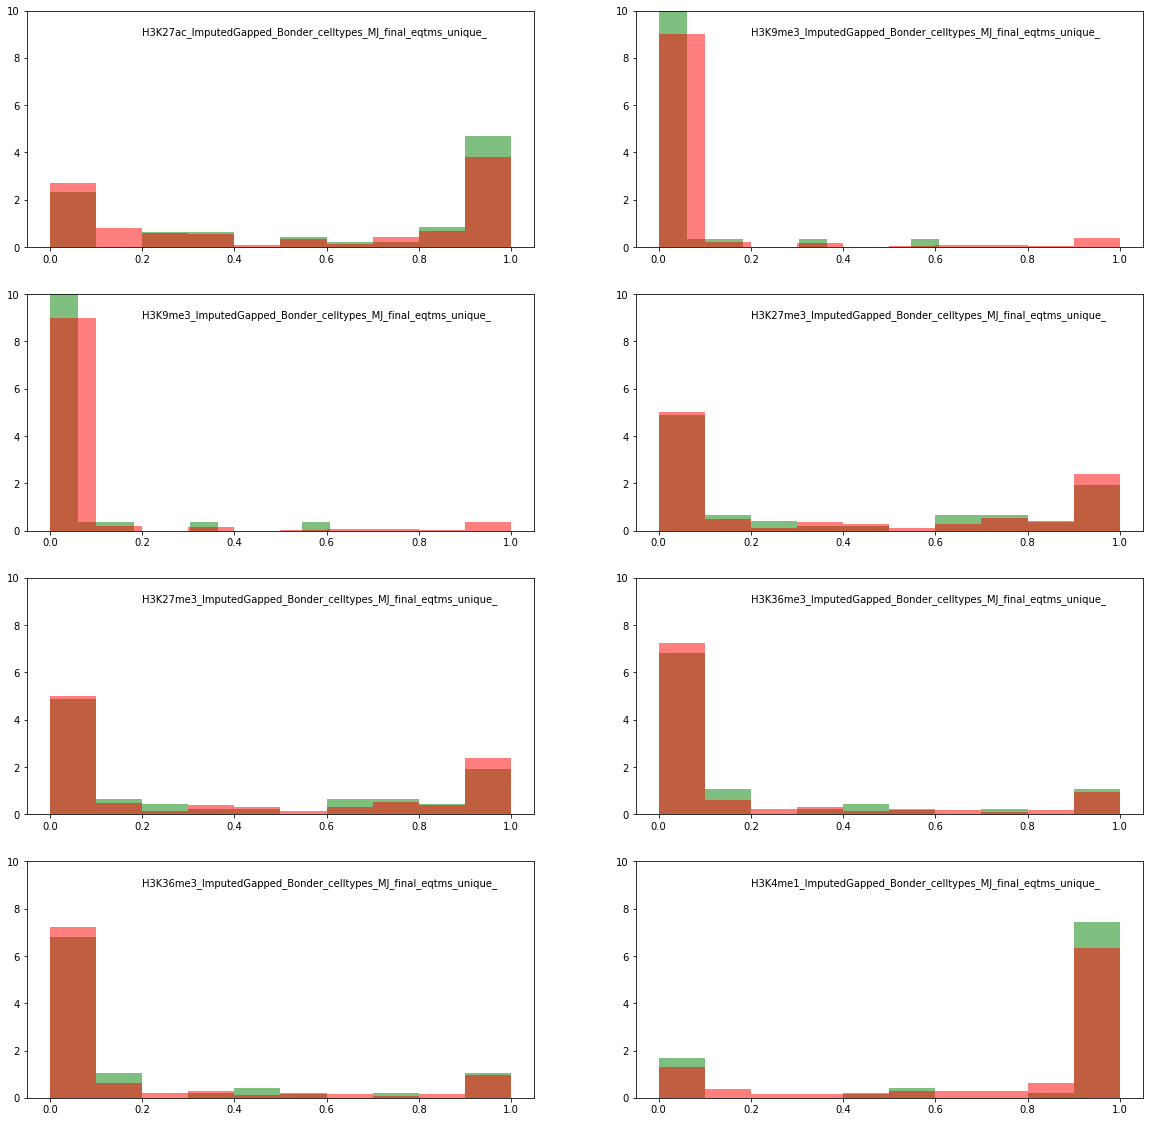

Positive cases.


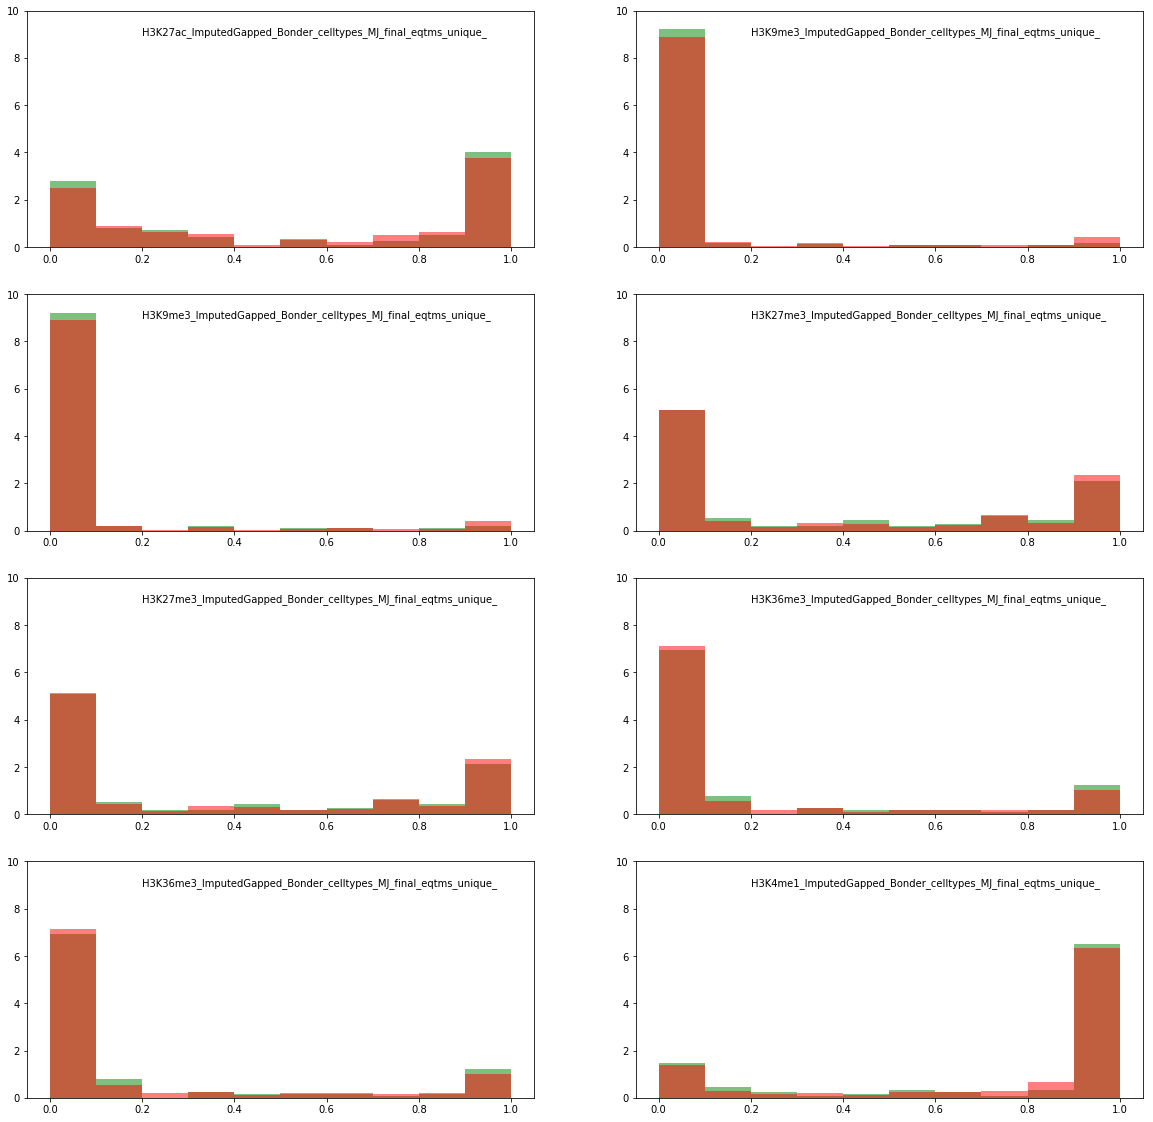

'Done.'

In [8]:
# plot the differences between two groups of cases
def plot_diff(error_cases, correct_cases):
    fig,ax = plt.subplots(4,2)
    fig.set_size_inches(20,20)
    for i in range(4):
        for j in range(2):
            col = error_cases.columns[i+j+1]
            ax[i][j].hist(error_cases[col],alpha=0.5,color='g',normed=True)
            ax[i][j].hist(correct_cases[col],alpha=0.5,color='r',normed=True)
            ax[i][j].set_ylim(0,10)
            ax[i][j].text(0.2,9,col)
    plt.show()
    return 'Done.'
print('Negative cases.')
plot_diff(error_cases_neg,correct_cases_neg)
# plt.show()
print('Positive cases.')
plot_diff(error_cases_pos,correct_cases_pos)
# plt.()

(0.1, 0.0001)

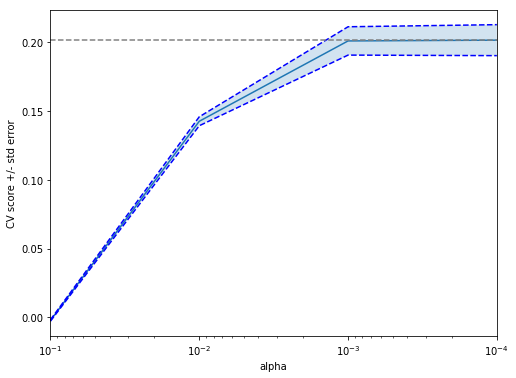

In [9]:
    # try regression models
    reg_train_labels = eqtm_data.train.values['zscore']
    reg_test_labels = eqtm_data.test.values['zscore']
    
    alphas = [0.1,0.01,0.001,0.0001]
    pipeline = Pipeline(steps=[('lasso',Lasso())])
    param_grid_lasso = [{'lasso__alpha':alphas}]
    n_folds = 5
    classifier_lasso = GridSearchCV(estimator=pipeline,
                                    param_grid=param_grid_lasso,
                                    cv=n_folds, refit=False)
    classifier_lasso.fit(train_data,reg_train_labels)
    scores = classifier_lasso.cv_results_['mean_test_score']
    scores_std = classifier_lasso.cv_results_['std_test_score']
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(alphas, scores)
    
    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)

    plt.semilogx(alphas, scores + std_error, 'b--')
    plt.semilogx(alphas, scores - std_error, 'b--')

    # alpha=0.2 controls the translucency of the fill color
    plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('CV score +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.max(scores), linestyle='--', color='.5')
    plt.xlim([alphas[0], alphas[-1]])
    
    
#     elastic_model = Lasso(alpha=0.001)
#     elastic_model.fit(train_data,reg_train_labels)
    
#     print(elastic_model.coef_)
#     train_score = elastic_model.score(train_data,reg_train_labels)
#     print(train_score)
#     test_score = elastic_model.score(test_data,reg_test_labels)

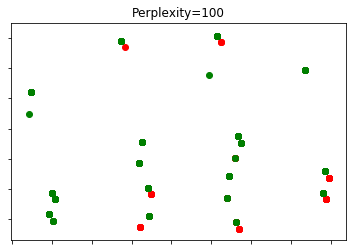

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time
n_components=2
perplexities = [100]

X = np.array(train_data,np.int8)
Y = np.array(eqtm_data.train.labels,np.int8)

green = Y == 1
red = Y == 0

ax = plt.subplot(111)
t0 = time()
tsne = TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=100)
pca = PCA()
Y = pca.fit_transform(X)
# Y = tsne.fit_transform(X)
t1 = time()
# print("circles, perplexity=%d in %.2g sec" % (10, t1 - t0))
ax.set_title("Perplexity=%d" % 100)
ax.scatter(Y[red, 0], Y[red, 1], c="r")
ax.scatter(Y[green, 0], Y[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.show()

In [12]:
pca.explained_variance_ratio_

array([5.69415284e-01, 1.60142282e-01, 8.68576889e-02, 7.38325908e-02,
       7.18855451e-02, 3.73865645e-02, 4.80045534e-04])

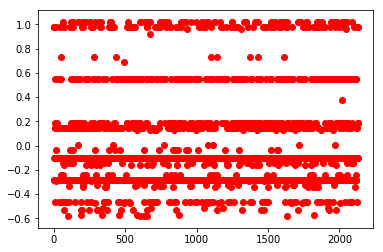

In [25]:
plt.scatter(np.arange(2131), Y[:,1], c="r")
plt.show()